In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import random
import gc

In [2]:
# Check if GPU is available 
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Paths
train_dir = r'C:\github_Repo\DS2024_Facial_Expression_Identification\Data and Data Preprocessing\raw_data\fer2013\train'
test_dir = r'C:\github_Repo\DS2024_Facial_Expression_Identification\Data and Data Preprocessing\raw_data\fer2013\test'

In [4]:
random.seed(2024)
torch.manual_seed(2024)
# Data Transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and Dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Print category information
print("Categories and number of images in each category (Training):")
for category, index in train_dataset.class_to_idx.items():
    print(f"{category}: {sum([label == index for _, label in train_dataset])} images")

print("Categories and number of images in each category (Testing):")
for category, index in test_dataset.class_to_idx.items():
    print(f"{category}: {sum([label == index for _, label in test_dataset])} images")

Categories and number of images in each category (Training):


UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='C:\\github_Repo\\DS2024_Facial_Expression_Identification\\Data and Data Preprocessing\\raw_data\\fer2013\\train\\angry\\Training_10118481.jpg'>

In [6]:
# Define the CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [7]:
# Instantiate Model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, verbose=True)

c:\Users\shiru\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
random.seed(2024)
torch.manual_seed(2024)

# Training Loop

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Train the model
num_epochs = 120
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    # ... training loop ...
    start_time = time.time()
    
    # Training loop 
    running_loss = 0  # Initialize running loss for the epoch
    
    correct = 0
    total = 0
    
    # Calculate training accuracy and loss
    total = 0
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()  # Accumulate loss
        
    train_accuracy = 100 * correct/total
    train_accuracies.append(train_accuracy)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Calculate test accuracy and loss
    # testing loop
    model.eval()
    running_loss = 0  # Initialize running loss for the epoch
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
        
            loss = criterion(outputs, labels)
        
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()  # Accumulate loss
        
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    # Calculate average training loss for the epoch
    epoch_test_loss = running_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    
    end_time = time.time()  # Record the end time of the epoch
    epoch_time = end_time - start_time  # Calculate the epoch time
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Time: {epoch_time:.2f} seconds')
print(f"Best Accuracy: {max(test_accuracies):.4f}")

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='C:\\github_Repo\\DS2024_Facial_Expression_Identification\\Data and Data Preprocessing\\raw_data\\fer2013\\train\\surprise\\Training_48632546.jpg'>

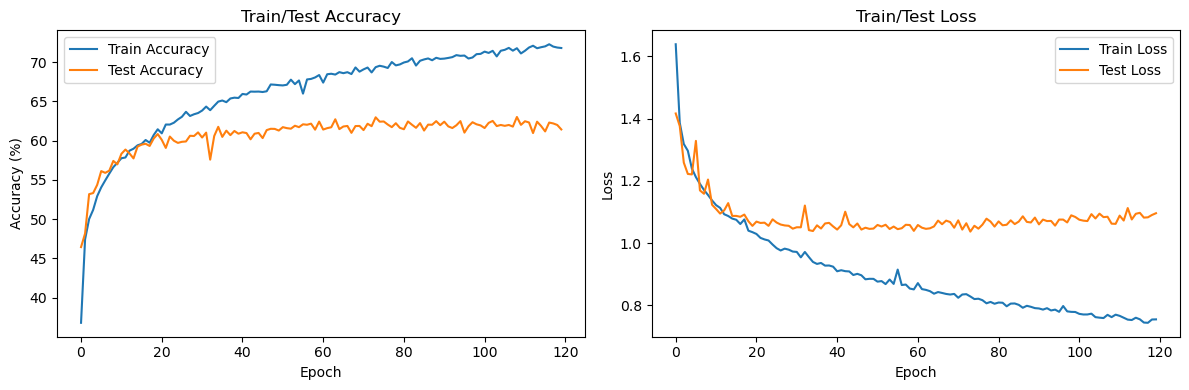

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [21]:
# model summarization
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'CNN_Best_Model.pth')

# load model
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('CNN_Best_Model.pth'))
# model.eval()

C:\Users\shiru\AppData\Local\Temp\ipykernel_26300\3251557911.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CNN_Best_Model.pth'))


RuntimeError: Error(s) in loading state_dict for VGG:
	Missing key(s) in state_dict: "features.0.weight", "features.0.bias", "features.2.weight", "features.2.bias", "features.5.weight", "features.5.bias", "features.7.weight", "features.7.bias", "features.10.weight", "features.10.bias", "features.12.weight", "features.12.bias", "features.14.weight", "features.14.bias", "features.17.weight", "features.17.bias", "features.19.weight", "features.19.bias", "features.21.weight", "features.21.bias", "features.24.weight", "features.24.bias", "features.26.weight", "features.26.bias", "features.28.weight", "features.28.bias", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 
	Unexpected key(s) in state_dict: "conv_layers.0.weight", "conv_layers.0.bias", "conv_layers.2.weight", "conv_layers.2.bias", "conv_layers.2.running_mean", "conv_layers.2.running_var", "conv_layers.2.num_batches_tracked", "conv_layers.4.weight", "conv_layers.4.bias", "conv_layers.6.weight", "conv_layers.6.bias", "conv_layers.6.running_mean", "conv_layers.6.running_var", "conv_layers.6.num_batches_tracked", "conv_layers.8.weight", "conv_layers.8.bias", "conv_layers.10.weight", "conv_layers.10.bias", "conv_layers.10.running_mean", "conv_layers.10.running_var", "conv_layers.10.num_batches_tracked", "fc_layers.1.weight", "fc_layers.1.bias", "fc_layers.3.weight", "fc_layers.3.bias", "fc_layers.3.running_mean", "fc_layers.3.running_var", "fc_layers.3.num_batches_tracked", "fc_layers.5.weight", "fc_layers.5.bias". 